In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed_3/'
    
import os
from pathlib import Path

import pandas as pd
import numpy as np
import numpy.linalg as la
from scipy import stats

import patsy
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.panel import PooledOLS, compare

from linearmodels import IV2SLS

import seaborn as sns
import matplotlib.pyplot as plt

from utils import data_loader

In [2]:
reduced_terms_list, df_model = data_loader(output_filepath)

## Residuals model

In [3]:
f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
base_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
base_model_fe = base_model_fe.fit()

df_model['residual'] = base_model_fe.resids.values

## Residual explanation model

In [4]:
models = []

f = f'residual ~ 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
base_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
base_model_fe = base_model_fe.fit()

models.append(base_model_fe)
    
for v in reduced_terms_list:

    f = f'residual ~ {v} + 1'
    y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
    base_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
    base_model_fe = base_model_fe.fit()
    
    models.append(base_model_fe)
    

c = compare(dict(zip(['base model'] + reduced_terms_list, models)), precision='pvalues', stars=True)
#print(c.summary.as_latex())
c.summary

,base model,financial_hubs,financial_authorities,goods_hubs,goods_authorities,human_hubs,human_in_favor
Dep. Variable,residual,residual,residual,residual,residual,residual,residual
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,693,693,693,693,693,693,693
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted
R-squared,0.0000,0.0064,6.392e-05,0.0289,0.0335,0.0143,0.0087
R-Squared (Within),0.0000,0.0061,5.809e-05,0.0273,0.0309,0.0131,0.0081
R-Squared (Between),0.0000,-2.873e+26,-4.297e+24,-1.412e+27,-2.666e+27,-1.962e+26,-7.074e+26
R-Squared (Overall),0.0000,-0.1399,-0.0021,-0.6902,-1.3238,-0.0866,-0.3513
F-statistic,,4.0103,0.0396,18.413,21.445,8.9823,5.4148
P-value (F-stat),,0.0457,0.8424,0.0000,0.0000,0.0028,0.0203


In [5]:
reduced_terms_regression = ' + '.join(reduced_terms_list)

# Extended model
f = f'residual ~ {reduced_terms_regression} + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
extended_model = PooledOLS(y,X)
extended_model = extended_model.fit()

f = f'residual ~ {reduced_terms_regression} + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
extended_model_re = RandomEffects(y,X)
extended_model_re = extended_model_re.fit()

f = f'residual ~ {reduced_terms_regression} + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
extended_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
extended_model_fe = extended_model_fe.fit()

c = compare({'Base Model Fixed Effects':base_model_fe,
             'Extended Model Random Effects':extended_model_re,
             'Extended Model Fixed Effects':extended_model_fe}, precision='pvalues', stars=True)
#print(c.summary.as_latex())
c.summary

,Base Model Fixed Effects,Extended Model Random Effects,Extended Model Fixed Effects
Dep. Variable,residual,residual,residual
Estimator,PanelOLS,RandomEffects,PanelOLS
No. Observations,693,693,693
Cov. Est.,Unadjusted,Unadjusted,Unadjusted
R-squared,0.0087,0.0054,0.1439
R-Squared (Within),0.0081,0.0106,0.1344
R-Squared (Between),-7.074e+26,-1.015e+25,-8.803e+27
R-Squared (Overall),-0.3513,0.0054,-4.3382
F-statistic,5.4148,0.6228,17.204
P-value (F-stat),0.0203,0.7122,0.0000


In [6]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1.e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 

    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(extended_model_fe, extended_model_re) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 99.49312942603224
degrees of freedom: 7
p-Value: 1.3727770461422824e-18


## Lasso

In [7]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'alpha': np.arange(0.1,0.9,0.1), 
   'l1_ratio': np.arange(0.1,0.9,0.1),
   'fit_intercept':[True],
   'normalize': [True],
   'selection':['cyclic', 'random'],
   'max_iter':[10000]}]


X = df_model[reduced_terms_list].values
y = df_model[['residual']].values

reg = GridSearchCV(
        ElasticNet(), param_grid)
reg.fit(X, y)
    

print(reg.best_estimator_.alpha)

print(reg.best_estimator_.intercept_)

pd.DataFrame({'variable':reduced_terms_list, 
              'coefficient':reg.best_estimator_.coef_}).sort_values(by='coefficient', ascending=False)

0.1
[1.04582048e-15]


,variable,coefficient
0,financial_hubs,-0.0
1,financial_authorities,-0.0
2,goods_hubs,0.0
3,goods_authorities,0.0
4,human_hubs,-0.0
5,human_in_favor,-0.0


## PCA

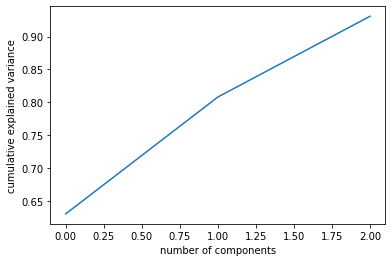

Dep. Variable:,residual,R-squared:,0.0032
Estimator:,PanelOLS,R-squared (Between):,-5.631e+24
No. Observations:,693,R-squared (Within):,0.0060
Date:,"Tue, Feb 01 2022",R-squared (Overall):,0.0032
Time:,15:56:33,Log-likelihood,790.81
Cov. Estimator:,Unadjusted,,
,,F-statistic:,0.7326
Entities:,63,P-value,0.5328
Avg Obs:,11.000,Distribution:,"F(3,689)"
Min Obs:,11.000,,
Max Obs:,11.000,F-statistic (robust):,0.7326


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

n = 3

## PCA ---------
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )

all_terms = reduced_terms_list.copy()
df_model[[f'pca_{i}' for i in range(n)]] = pipe.fit_transform(df_model[all_terms])

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )
pipe.fit(df_model[all_terms])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

## regression ---------
f = 'residual ~ 1 + ' + ' + '.join([f'pca_{i}' for i in range(n)])
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = PanelOLS(y,X, entity_effects=True, time_effects=True)
model = RandomEffects(y,X)
model = PanelOLS(y,X)
results = model.fit()
results.summary

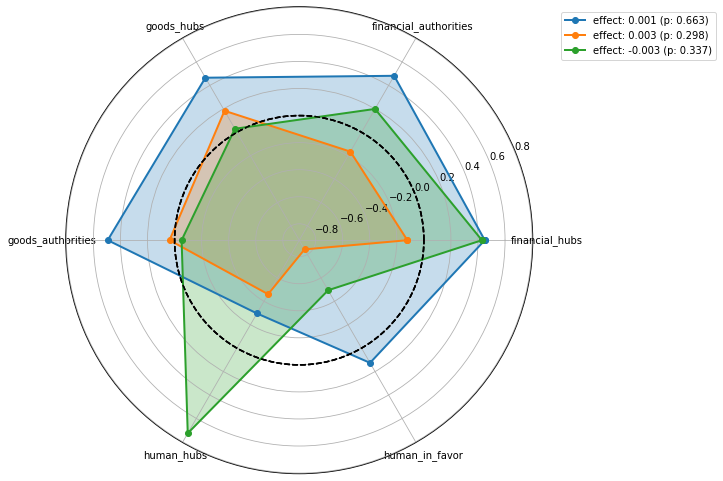

In [9]:
df_radar = pd.DataFrame(pipe['reduce_dims'].components_, columns = all_terms)
df_radar.loc[:,'coefs'] = pd.Series(results.params[[f'pca_{i}' for i in range(n)]].values)
df_radar['pvalues'] = pd.Series(results.pvalues[[f'pca_{i}' for i in range(n)]].values)

labels = all_terms.copy()
stats = pipe['reduce_dims'].components_[0]

angles=np.linspace(0, 2*np.pi, len(all_terms), endpoint=False)
circle_angles = np.linspace(0, 2*np.pi, 1000, endpoint=True)

fig=plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, polar=True)

for i in range(n):
    stats = df_radar.loc[i,all_terms]
    c = round(df_radar.loc[i,'coefs'], 3)
    p =  round(df_radar.loc[i,'pvalues'], 3)
    ax.plot(np.concatenate((angles,[angles[0]])), np.concatenate((stats,[stats[0]])), 
            'o-', 
            linewidth=2, 
            label = f'effect: {c} (p: {p})'
    )
    ax.fill(angles, stats, alpha=0.25)
    ax.plot(circle_angles, np.zeros_like(circle_angles), 'k--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)

plt.tight_layout()
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'pca_results.png')
plt.savefig(save_to)    
plt.show()